We will use the classification models of XGBoost to predict the profile of target customers.  
To proceed with the machine learning, we have to convert the categorical variables into numerical variables first using one hot encoding.

In [1]:
%pip install xgboost
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, f1_score, roc_auc_score


In [3]:
customerdata = pd.read_csv('customer_bank_marketing_data.csv')
customerdata

,age,job,marital,education,default,balance,housing,loan,deposit_num
0,59,administrative,married,secondary,no,2343,yes,no,1
1,56,administrative,married,secondary,no,45,no,no,1
2,41,technician,married,secondary,no,1270,yes,no,1
3,55,services,married,secondary,no,2476,yes,no,1
4,54,administrative,married,tertiary,no,184,no,no,1
...,...,...,...,...,...,...,...,...,...
45202,59,management,married,tertiary,no,138,yes,yes,0
45203,37,management,married,tertiary,no,1428,no,no,0
45204,34,blue-collar,single,secondary,no,1475,yes,no,0
45205,57,blue-collar,married,secondary,no,668,no,no,0


# One Hot Encoding

In [4]:
#all categorical variables are converted into dummy variables using the pd.get_dummies function.
#each new added columns represents one category and contains 1 if the category is present.

catcols = ['job','marital','education','default','housing','loan']
for var in catcols:
    customerdata = pd.concat([customerdata.drop(var, axis=1), pd.get_dummies(customerdata[var], prefix=var, prefix_sep='_', drop_first=True, dummy_na=False, dtype=int)], axis=1)
customerdata   

,age,balance,deposit_num,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes
0,59,2343,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
1,56,45,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,41,1270,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
3,55,2476,1,0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
4,54,184,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45202,59,138,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,1
45203,37,1428,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
45204,34,1475,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
45205,57,668,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


# XGBoost Model Training

In [5]:
#the dataframe x will contain all the independent variables
#the dataframe y will only contain the dependent variable -> deposit_num

x = customerdata.drop(columns = 'deposit_num')
y = customerdata[['deposit_num']]
customerdata

,age,balance,deposit_num,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes
0,59,2343,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
1,56,45,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,41,1270,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
3,55,2476,1,0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
4,54,184,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45202,59,138,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,1
45203,37,1428,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
45204,34,1475,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
45205,57,668,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [6]:
#the test size is set to 30% of the data
#random state is set to ensure the reproducibility of results.
#it allows us to obtain the same random behaviour everytime we run the code

test_size = 0.3
rand_state = 40

# Split the dataset into features (X) and target (y)
X = customerdata.drop('deposit_num', axis=1)
y = customerdata['deposit_num']

# Before Tuning

Training accuracy: 0.893
Testing accuracy: 0.879

F1 Score: 0.078
Accuracy: 0.879
AUC: 0.705

Performance Metrics:
True Positive Rate (TPR): 0.04257907542579075
False Positive Rate (FPR): 0.005956875576810135
True Negative Rate (TNR): 0.9940431244231899
False Negative Rate (FNR): 0.9574209245742092


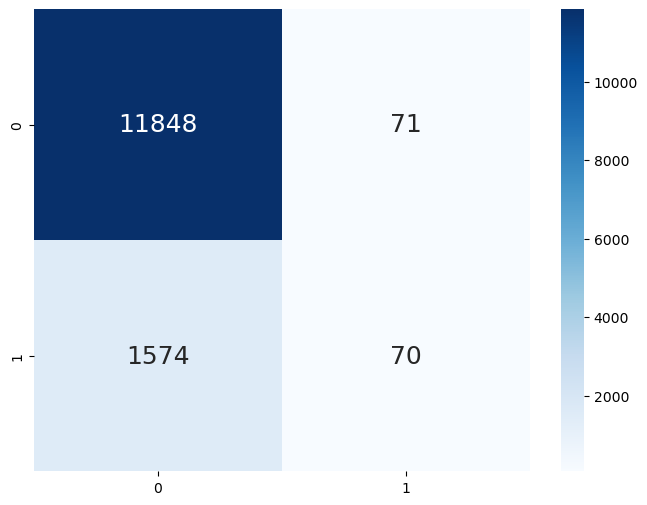

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=rand_state)

#train XGBoost model
xgb = XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train.squeeze().values)

#calculate and print scores for the model
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)
print(f"Training accuracy: {xgb.score(X_train, y_train):.3f}")
print(f"Testing accuracy: {xgb.score(X_test, y_test):.3f}")

# Predict the labels for the test set
y_test_pred = xgb.predict(X_test)

# Calculate F1 score
f1 = f1_score(y_test, y_test_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_test_pred)

# Calculate AUC
y_prob = xgb.predict_proba(X_test)[:, 1]  # Probability of positive class
auc = roc_auc_score(y_test, y_prob)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

print()
print(f"F1 Score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print(f"AUC: {auc:.3f}")
print()
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sb.heatmap(cm, annot=True, fmt=".0f", annot_kws={"size":18}, cmap="Blues")

tn, fp, fn, tp = cm.ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tnr = tn / (tn + fp)
fnr = fn / (fn + tp)

print("Performance Metrics:")
print("True Positive Rate (TPR):", tpr)
print("False Positive Rate (FPR):", fpr)
print("True Negative Rate (TNR):", tnr)
print("False Negative Rate (FNR):", fnr)

n_estimators - represent the number of trees to build. Higher values allow the model to learn more complex patterns but can increase the risk of overfitting

learning_rate - controls the step size at each iteration while finding minimum cost function. Lower value make the model training more robust

subsample - determine the fraction of samples to be used for training each tree

colsample_bytree - determines the fraction of columns to be randomly sampled and used to build each tree

max_depth - set the maximum depth of the tree

# After Tuning

Training accuracy: 0.830
Testing accuracy: 0.820

F1 Score: 0.280
Accuracy: 0.820
AUC: 0.668


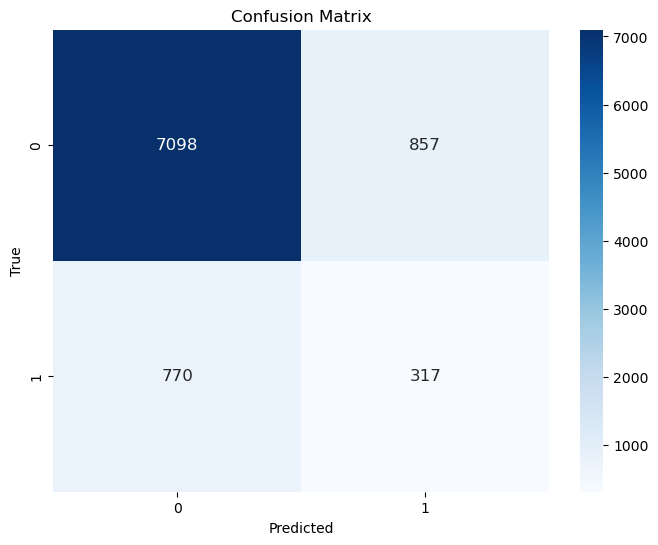


Performance Metrics:
True Positive Rate (TPR): 0.29162833486660533
False Positive Rate (FPR): 0.10773098680075424
True Negative Rate (TNR): 0.8922690131992458
False Negative Rate (FNR): 0.7083716651333947


In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Define hyperparameters
hyperparams = {
    'n_estimators': 200,
    'learning_rate': 0.1,
    'max_depth': 5,
    'gamma': 0.1
}

# Train the XGBoost model with the defined hyperparameters
xgb = XGBClassifier(**hyperparams)
xgb.fit(X_train_smote, y_train_smote)

# Evaluate the model
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)
f1 = f1_score(y_test, y_test_preds)
accuracy = accuracy_score(y_test, y_test_preds)
auc = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])
cm = confusion_matrix(y_test, y_test_preds)

# Print evaluation metrics
print(f"Training accuracy: {xgb.score(X_train, y_train):.3f}")
print(f"Testing accuracy: {xgb.score(X_test, y_test):.3f}")
print()
print(f"F1 Score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print(f"AUC: {auc:.3f}")

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sb.heatmap(cm, annot=True, fmt=".0f", annot_kws={"size": 12}, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

tn, fp, fn, tp = cm.ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tnr = tn / (tn + fp)
fnr = fn / (fn + tp)

print()
print("Performance Metrics:")
print("True Positive Rate (TPR):", tpr)
print("False Positive Rate (FPR):", fpr)
print("True Negative Rate (TNR):", tnr)
print("False Negative Rate (FNR):", fnr)

SMOTE is employed to handle class imbalance in the dataset where the class deposit=0 significantly outweighs the class deposit=1.  Class imbalance poses a challenge in machine learning, as models trained on imbalanced data may exhibit bias towards the majority class, leading to poor performance on the minority class.

SMOTE works by creating synthetic examples along the line segments joining k=5(by default) minority class nearest neighbors in the feature space. This process helps to increase the representation of the minority class, thereby alleviating the class imbalance issue in the dataset.

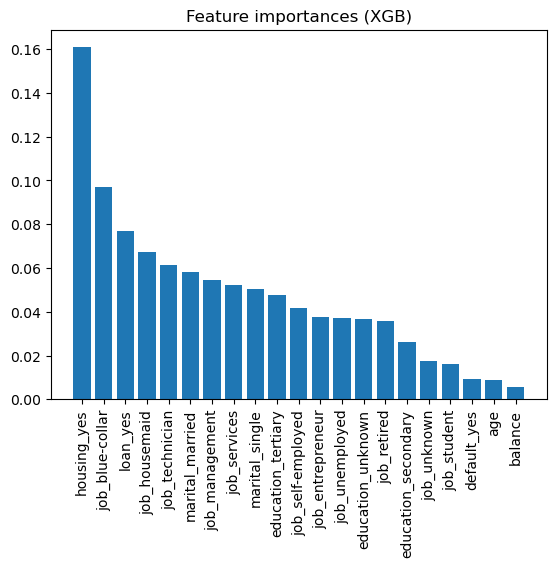

In [12]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)

#plot feature importances
x_pos = np.arange(0, len(xgb_feature_importances))
plt.bar(x_pos, xgb_feature_importances['score'])
plt.xticks(x_pos, xgb_feature_importances['name'])
plt.xticks(rotation=90)
plt.title('Feature importances (XGB)')

plt.show()

From the graph, we can see that the top 3 variables that we can used to estimate our target customers would be housing_yes, job_blue-collar and loan_yes.

# Conclusion from XGBoost

From the machine leraning model of XGBoost:

Initial model performance: 

Training accuracy: 0.893  
Testing accuracy: 0.879  
F1 Score: 0.078  
Accuracy: 0.879  
AUC: 0.705  
True Positive Rate (TPR): 0.04257907542579075   
False Positive Rate (FPR): 0.005956875576810135   
True Negative Rate (TNR): 0.9940431244231899  
False Negative Rate (FNR): 0.9574209245742092    
    
 
     
Tuned model performance:  

Training accuracy: 0.830  
Testing accuracy: 0.820  
F1 Score: 0.280   
Accuracy: 0.820  
AUC: 0.668     
True Positive Rate (TPR): 0.29162833486660533  
False Positive Rate (FPR): 0.10773098680075424   
True Negative Rate (TNR): 0.8922690131992458   
False Negative Rate (FNR): 0.7083716651333947    

XGBoost model performs better after tuning. This is because: 

Higher F1 Score: The second set has a higher F1 score of 0.280 compared to 0.078 in the first set. The F1 score considers both precision and recall, making it a good overall measure of model performance, especially when dealing with imbalanced datasets where deposit=0 outweights deposit=1.


Similar Accuracy: Although the testing accuracy is slightly lower in the second set (0.820) compared to the first set (0.879), the difference is not substantial. Accuracy alone may not be the best metric for evaluating imbalanced datasets, as it can be misleading when the classes are unevenly distributed.


Comparable AUC: The AUC (Area Under the ROC Curve) is slightly lower in the second set (0.668) compared to the first set (0.705). However, the difference is not significant, and both values indicate reasonable performance in terms of the model's ability to distinguish between positive and negative cases.


Better True Positive Rate (TPR): The second set has a higher TPR of approximately 29.16% compared to 4.26% in the first set. A higher TPR indicates that the model in the second set is better at correctly identifying positive cases, which is crucial, especially in scenarios where correctly identifying cases of whether customers will made a term deposit is of greater importance.

While the original model has higher training and testing accuracies, accuracy alone may not provide a comprehensive assessment of the model's performance, especially in this case of siginificantly imbalanced datasets.

Hence, we might expect the future customer who have a higher posibility in making a term deposit to be those with housing loan, blue-collar and with personal loan.